This is Will Bruces attept at a linear regression model to predict life expectancy of the ___ dataset

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn import model_selection
%matplotlib inline

In [7]:
def rlr_validate(X,y,lambdas,cvf=10):
    ''' Validate regularized linear regression model using 'cvf'-fold cross validation.
        Find the optimal lambda (minimizing validation error) from 'lambdas' list.
        The loss function computed as mean squared error on validation set (MSE).
        Function returns: MSE averaged over 'cvf' folds, optimal value of lambda,
        average weight values for all lambdas, MSE train&validation errors for all lambdas.
        The cross validation splits are standardized based on the mean and standard
        deviation of the training set when estimating the regularization strength.
        
        Parameters:
        X       training data set
        y       vector of values
        lambdas vector of lambda values to be validated
        cvf     number of crossvalidation folds     
        
        Returns:
        opt_val_err         validation error for optimum lambda
        opt_lambda          value of optimal lambda
        mean_w_vs_lambda    weights as function of lambda (matrix)
        train_err_vs_lambda train error as function of lambda (vector)
        test_err_vs_lambda  test error as function of lambda (vector)
    '''
    CV = model_selection.KFold(cvf, shuffle=True)
    M = X.shape[1]
    w = np.empty((M,cvf,len(lambdas)))
    train_error = np.empty((cvf,len(lambdas)))
    test_error = np.empty((cvf,len(lambdas)))
    f = 0
    y = y.squeeze()
    for train_index, test_index in CV.split(X,y):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
        # Standardize the training and set set based on training set moments
        mu = np.mean(X_train[:, 1:], 0)
        sigma = np.std(X_train[:, 1:], 0)
        
        X_train[:, 1:] = (X_train[:, 1:] - mu) / sigma
        X_test[:, 1:] = (X_test[:, 1:] - mu) / sigma
        
        # precompute terms
        Xty = X_train.T @ y_train
        XtX = X_train.T @ X_train
        for l in range(0,len(lambdas)):
            # Compute parameters for current value of lambda and current CV fold
            # note: "linalg.lstsq(a,b)" is substitue for Matlab's left division operator "\"
            lambdaI = lambdas[l] * np.eye(M)
            lambdaI[0,0] = 0 # remove bias regularization
            w[:,f,l] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
            # Evaluate training and test performance
            train_error[f,l] = np.power(y_train-X_train @ w[:,f,l].T,2).mean(axis=0)
            test_error[f,l] = np.power(y_test-X_test @ w[:,f,l].T,2).mean(axis=0)
    
        f=f+1

    opt_val_err = np.min(np.mean(test_error,axis=0))
    opt_lambda = lambdas[np.argmin(np.mean(test_error,axis=0))]
    train_err_vs_lambda = np.mean(train_error,axis=0)
    test_err_vs_lambda = np.mean(test_error,axis=0)
    mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))
    
    return opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda

This now we have all required imports we will now use the standadized data file with the Developed and Developing country status binorised as 1 and 0.

In [8]:
data = pd.read_csv("StandardizedDataFrameWithNansFilled.csv", index_col=0)
data["Status"] = [1 if stat == "Developed" else 0 for stat in data["Status"]]
data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,0,-0.444372,0.791452,0.268778,-1.139938,-0.335513,-0.110366,-0.964550,0.255316,-3.254219,0.911749,-0.723742,-0.32339,2.812651,2.772807,-0.725277,-0.579832
1,Afghanistan,2014,0,-0.980783,0.855926,0.285738,-1.139938,-0.334384,-0.168095,-0.989641,0.274014,-1.039197,0.919893,-0.850094,-0.32339,2.880918,2.817423,-0.739924,-0.610466
2,Afghanistan,2013,0,-0.980783,0.831748,0.302697,-1.139938,-0.334537,-0.173502,-1.014732,0.292712,-0.868811,0.899533,-0.765859,-0.32339,2.926429,2.862039,-0.769218,-0.641099
3,Afghanistan,2012,0,-1.022854,0.863985,0.328137,-1.139938,-0.332040,0.032040,-1.039823,0.317642,-0.655828,1.058344,-0.639507,-0.32339,2.971940,2.928963,-0.803395,-0.671733
4,Afghanistan,2011,0,-1.054408,0.888163,0.345097,-1.139938,-0.367800,0.051748,-1.059895,0.342573,-0.613232,0.793659,-0.597390,-0.32339,3.040207,2.973578,-0.847336,-0.763634


In [84]:
column_names = data.columns

print(column_names)

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Measles ',
       ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')


In [9]:
# Split dataset into features and target vector
Life_expectancy = data['Life expectancy ']
data = data.drop(['Life expectancy ','Country','Year'], axis=1)
data.head()

,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,0,0.791452,0.268778,-1.139938,-0.335513,-0.110366,-0.964550,0.255316,-3.254219,0.911749,-0.723742,-0.32339,2.812651,2.772807,-0.725277,-0.579832
1,0,0.855926,0.285738,-1.139938,-0.334384,-0.168095,-0.989641,0.274014,-1.039197,0.919893,-0.850094,-0.32339,2.880918,2.817423,-0.739924,-0.610466
2,0,0.831748,0.302697,-1.139938,-0.334537,-0.173502,-1.014732,0.292712,-0.868811,0.899533,-0.765859,-0.32339,2.926429,2.862039,-0.769218,-0.641099
3,0,0.863985,0.328137,-1.139938,-0.332040,0.032040,-1.039823,0.317642,-0.655828,1.058344,-0.639507,-0.32339,2.971940,2.928963,-0.803395,-0.671733
4,0,0.888163,0.345097,-1.139938,-0.367800,0.051748,-1.059895,0.342573,-0.613232,0.793659,-0.597390,-0.32339,3.040207,2.973578,-0.847336,-0.763634


In [10]:
# Fit ordinary least squares regression model
model = lm.LinearRegression()
model.fit(data,Life_expectancy)

LinearRegression()

NameError: name 'y' is not defined

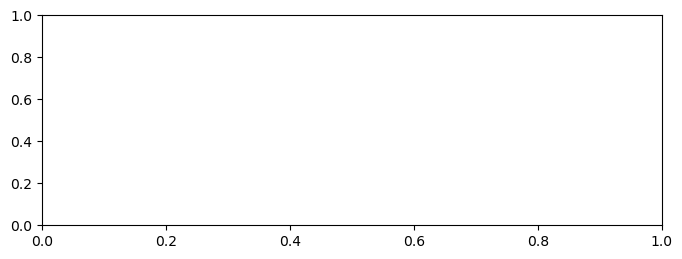

In [11]:
# Predict alcohol content
y_est = model.predict(data)
residual = y_est-Life_expectancy

# Display scatter plot
plt.figure(figsize=(8, 6))
plt.subplot(2,1,1)
plt.plot(y, y_est, '.')
plt.xlabel('Life expectancy (true)'); plt.ylabel('Life expectancy (estimated)')
plt.subplots_adjust(hspace=0.4)

plt.subplot(2,1,2)
plt.hist(residual,40)

plt.show()

The top plot expresses the life expectancy estimated by the model against the true life expectancy.
The bottom plot 

In [12]:
data = pd.read_csv("StandardizedDataFrameWithNansFilled.csv", index_col=0)
data["Status"] = [1 if stat == "Developed" else 0 for stat in data["Status"]]
data.head()



,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,0,-0.444372,0.791452,0.268778,-1.139938,-0.335513,-0.110366,-0.964550,0.255316,-3.254219,0.911749,-0.723742,-0.32339,2.812651,2.772807,-0.725277,-0.579832
1,Afghanistan,2014,0,-0.980783,0.855926,0.285738,-1.139938,-0.334384,-0.168095,-0.989641,0.274014,-1.039197,0.919893,-0.850094,-0.32339,2.880918,2.817423,-0.739924,-0.610466
2,Afghanistan,2013,0,-0.980783,0.831748,0.302697,-1.139938,-0.334537,-0.173502,-1.014732,0.292712,-0.868811,0.899533,-0.765859,-0.32339,2.926429,2.862039,-0.769218,-0.641099
3,Afghanistan,2012,0,-1.022854,0.863985,0.328137,-1.139938,-0.332040,0.032040,-1.039823,0.317642,-0.655828,1.058344,-0.639507,-0.32339,2.971940,2.928963,-0.803395,-0.671733
4,Afghanistan,2011,0,-1.054408,0.888163,0.345097,-1.139938,-0.367800,0.051748,-1.059895,0.342573,-0.613232,0.793659,-0.597390,-0.32339,3.040207,2.973578,-0.847336,-0.763634


In [13]:
y = data['Life expectancy '].values
y=y.T
X_drop = data.drop(columns = ['Country','Year','Life expectancy '])




In [14]:
# Add offset attribute
attributeNames = X_drop.columns
X_drop = np.concatenate((np.ones((X_drop.shape[0],1)),X_drop),1)
attributeNames = [u'Offset']+attributeNames
N, M = X_drop.shape
X = X_drop


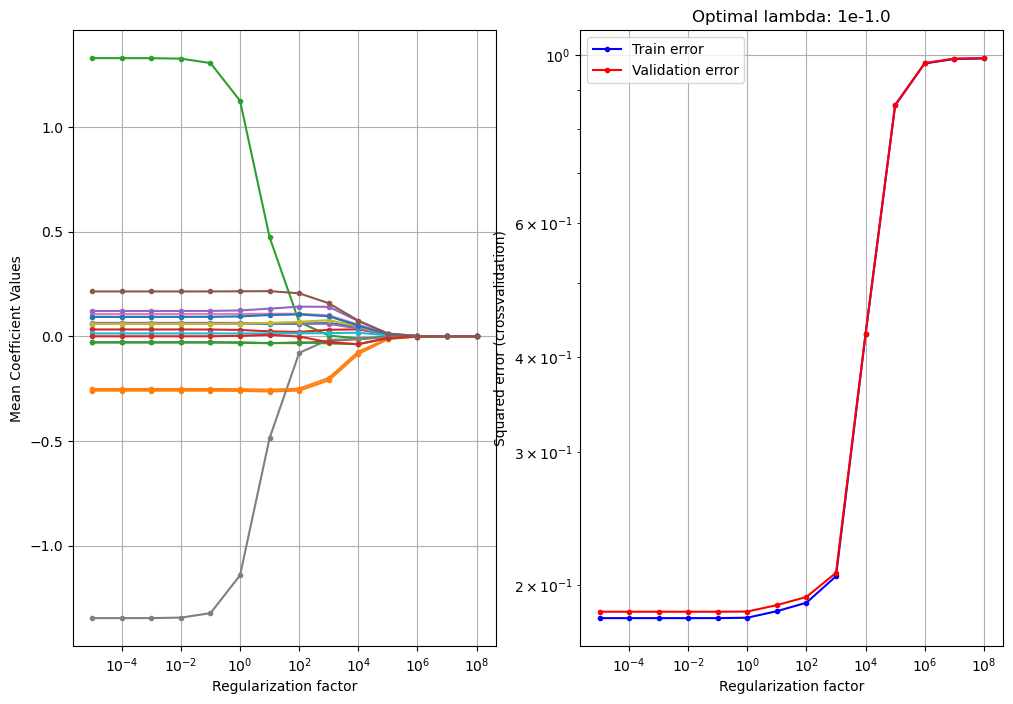

In [15]:
## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)
#CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.,range(-5,9))
# Initialize variables

#T = len(lambdas)
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10    
    
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        plt.figure(k, figsize=(12,8))
        plt.subplot(1,2,1)
        plt.semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        plt.xlabel('Regularization factor')
        plt.ylabel('Mean Coefficient Values')
        plt.grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        #legend(attributeNames[1:], loc='best')
        
        plt.subplot(1,2,2)
        plt.title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        plt.loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        plt.xlabel('Regularization factor')
        plt.ylabel('Squared error (crossvalidation)')
        plt.legend(['Train error','Validation error'])
        plt.grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1

In [16]:
plt.show()
# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
'''for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,-1],2)))'''

Linear regression without feature selection:
- Training error: 0.1811629525253283
- Test error:     0.18412621120498732
- R^2 train:     0.8187688384987418
- R^2 test:     0.8157050326835326

Regularized linear regression:
- Training error: 0.1811650171084675
- Test error:     0.1841075022471222
- R^2 train:     0.8187667731382742
- R^2 test:     0.8157237587886087

Weights in last fold:


"for m in range(M):\n    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,-1],2)))"

In [17]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [18]:
# exercise 8.1.1

from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend, 
                           title, subplot, show, grid)
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate

mat_data = loadmat('../Data/body.mat')
X = mat_data['X']
y = mat_data['y'].squeeze()
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)
#CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.,range(-5,9))

# Initialize variables
#T = len(lambdas)
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10    
    
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    #m = lm.LinearRegression().fit(X_train, y_train)
    #Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    #Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(12,8))
        subplot(1,2,1)
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        #legend(attributeNames[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error'])
        grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1

show()
# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,-1],2)))

print('Ran Exercise 8.1.1')

ModuleNotFoundError: No module named 'toolbox_02450'